In [1]:
import ee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import scipy
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

ee.Initialize()

def metrics(O, P):
    mae = sklearn.metrics.mean_absolute_error(O, P)
    mdae = sklearn.metrics.median_absolute_error(O, P)
    RSq = sklearn.metrics.r2_score(O, P)
    rmse = sklearn.metrics.mean_squared_error(O, P, squared=False)
    R2 = stats.linregress(O, P)[2]**2
    return mae, mdae, rmse, RSq, R2

def plot_regression(O, P):
    plt.figure(figsize = (6, 6))
#     plt.grid(zorder = 1)
    plt.scatter(O, P, edgecolor='#808080', facecolors='#C0C0C0', linewidth=1, zorder = 2)
    corr, _ = pearsonr(O, P)
    regmodel = LinearRegression()
    regmodel.fit(O.values.reshape(-1,1), P)
    rsq = regmodel.score(O.values.reshape(-1,1), P)
    obs, pred = O.values.reshape(-1,1), regmodel.predict(O.values.reshape(-1,1))
    plt.plot([obs.min(), obs.max()], [pred.min(), pred.max()], color = 'black', lw = 3, zorder = 3)
    plt.plot([-5, obs.max()], [-5, obs.max()], color = 'navy', ls = '--', zorder = 1)
    plt.legend([u'Pearson R\u00b2: {:.3f}'.format(corr**2), '1:1 Plot', 'Observed - Predicted'], loc = 2)
    plt.xlabel('In situ Precipitation [mm/month]')
    plt.ylabel('Satelite Precipitation [mm/month]')
    stats = np.round(metrics(O, P), 3)
    stats = pd.DataFrame(data = stats, index = ['MAE', 'MDAE', 'RMSE', 'RSq', u'R\u00b2'], columns = ['Metrics'])
    stats.loc['RSq'] = np.round((stats.loc['RSq']) , 2) * 100
    stats.loc[u'R\u00b2'] = np.round((stats.loc[u'R\u00b2']) , 2) * 100
    stats2 = pd.DataFrame(stats['Metrics'][:3].astype(str) + ' mm/d' )
    stats3 = pd.DataFrame(stats['Metrics'][3:].astype(str) + ' %' )
    stats = stats2.append(stats3)
    table = plt.table(cellText=stats.values, colWidths = [0.5]*len(stats.columns),
          rowLabels=stats.index,
#           colLabels=stats.columns,
          cellLoc = 'left', rowLoc = 'left',
          loc=4, edges='open')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(.5, 1.5)
#     return stats

   longitude latitude precipitation
1      22.99    40.54       93.6777
2      22.99    40.54       11.8838
3      22.99    40.54       11.9714
4      22.99    40.54       33.9079
5      22.99    40.54       32.7342
6      22.99    40.54       32.8328
7      22.99    40.54       31.4208
8      22.99    40.54        5.0256
9      22.99    40.54       19.3447
10     22.99    40.54         19.42
11     22.99    40.54       63.7343
12     22.99    40.54       51.2662


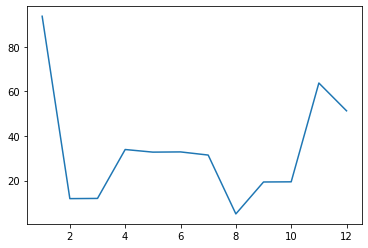

In [2]:
# import the RS products
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
 
# Define time range
startyear = 2019
endyear = 2020

# Set date in ee date format
startdate = ee.Date.fromYMD(startyear,1,1)
enddate = ee.Date.fromYMD(endyear+1,12,31)

 
# create list for years
years = range(startyear,endyear);
 
# make a list with months
months = range(1,13)

#Filter to select Precipitation band
PrecipitationChirps = chirps.filterDate(startdate, enddate).sort('system:time_start', False).select("precipitation")
 
# Define geograpic 
point = ee.Geometry.Point([22.99, 40.54])
 
# calculate the monthly Sum
def MonthlySum(imageCollection):
    mylist = ee.List([])
    for y in years:
        for m in months:
            w = imageCollection.filter(ee.Filter.calendarRange(y, y, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).sum()
            #mylist = mylist.add(w)
            mylist = mylist.add(w.set('year', y).set('month', m).set('date', ee.Date.fromYMD(y,m,1)).set('system:time_start',ee.Date.fromYMD(y,m,1)))
    return ee.ImageCollection.fromImages(mylist)
 
# run the calcMonthlyMean function
monthlyChirps = ee.ImageCollection(MonthlySum(PrecipitationChirps))


# select the region of interest, 25000 is the cellsize in meters
monthlyChirps = monthlyChirps.getRegion(point,1,"epsg:4326").getInfo()


# get january (index = 0)
precipiation = pd.DataFrame(monthlyChirps, columns = monthlyChirps[0])

# remove the first line
precipiation = precipiation[1:]

#to display the data
print(precipiation[['longitude','latitude','precipitation']])

precipitation_gee = pd.DataFrame(precipiation['precipitation']).astype(float)
plt.plot(precipiation.precipitation);

In [3]:
#Read AUTH Station data
auth = pd.read_excel("auth.xlsx", skiprows = [1, 2], index_col = 0, parse_dates = True, engine='openpyxl')

# auth = auth[['P']]
p = auth.P.loc['01-2008':].resample('M').sum()
p

Date
2008-01-31    23.4
2008-02-29    17.4
2008-03-31    15.2
2008-04-30    85.2
2008-05-31    27.6
              ... 
2020-06-30    25.6
2020-07-31    13.0
2020-08-31    74.8
2020-09-30    15.4
2020-10-31    15.0
Freq: M, Name: P, Length: 154, dtype: float64

In [4]:
precipitation_real = pd.DataFrame(p.groupby(p.index.month).median()).astype(float)

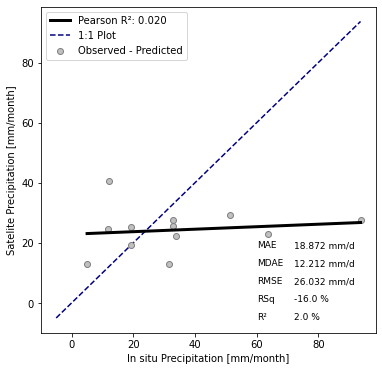

In [5]:
plot_regression(precipitation_gee['precipitation'], precipitation_real['P']);